In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.drop_width.preprocessing import DropDataProcessor
from src.drop_width.model import build_lstm_model
from src.drop_width.side_to_width import width_estim
from pathlib import Path




(3550.0, 4200.0)

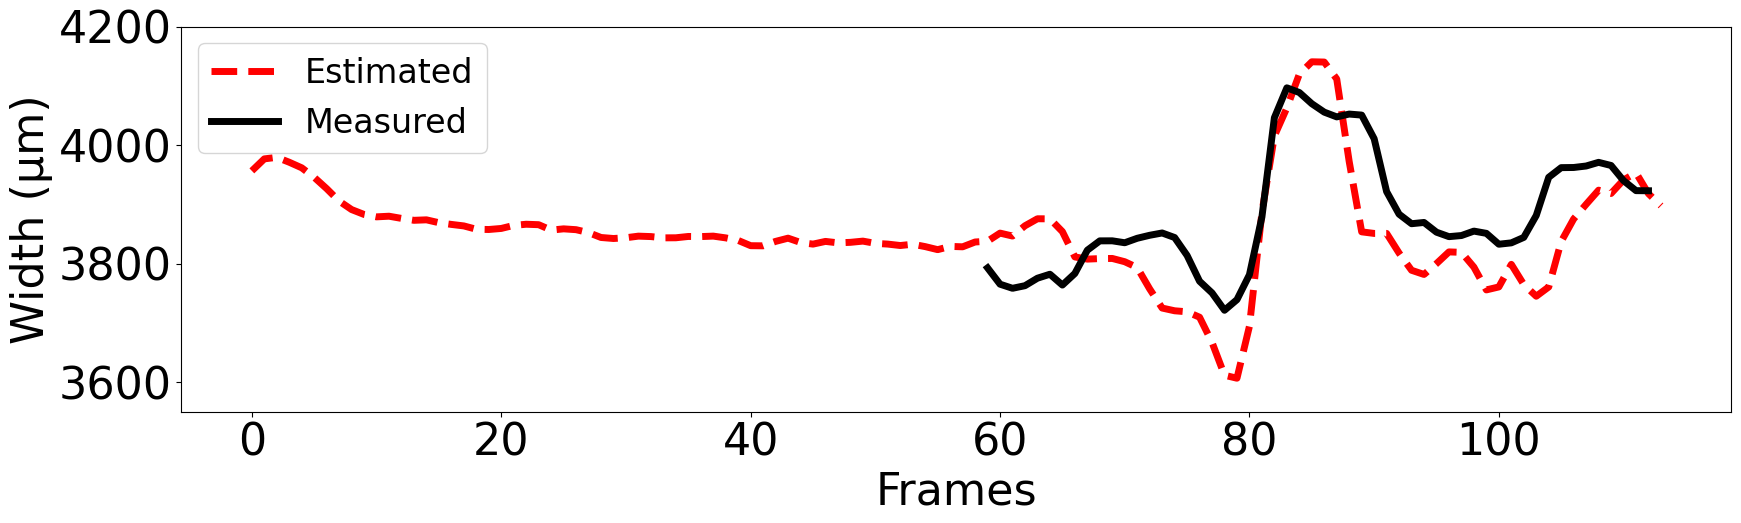

In [ ]:
# Load data from an Excel file
data_file_path = Path("data") / "dataset.xlsx"
df = pd.read_excel(data_file_path)
processor = DropDataProcessor(df)
train_data, test_data, train_label, test_label, train_data_notnormalized=processor.extract_data_label()

# Define the sliding window size
slide_window = 20
train_data_sliced, train_label_sliced= processor.slice_patch(slide_window, train_data, train_label)

# Define the model
model, X_train, X_val, y_train, y_val = build_lstm_model(
    train_data_sliced, train_label_sliced, slide_window
)

# Load the pre-trained model weights
model.load_weights(Path("models") / "lstm_weights.h5")

# Filter the DataFrame for a specific "Video ID"
video_id = 234
df_valid = df[df["Video ID"] == video_id]

# Estimation
y_pred, measured_width = width_estim(df_valid, model, processor, train_data_notnormalized, slide_window)

# Plotting configuration
plt.rcParams["figure.figsize"] = (20, 5)
font_size = 32

# Plot the data
plt.xlabel('Frames', fontdict={'size': font_size})
plt.ylabel('Width (μm)', fontdict={'size': font_size})
plt.plot(y_pred, color='red', linestyle='dashed', linewidth=5, label="Estimated")
plt.plot(range(0, len(measured_width)), measured_width, "black", linewidth=5, label="Measured")
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.legend(fontsize=24, loc='upper left')
plt.ylim(3550, 4200)


(3800.0, 4200.0)

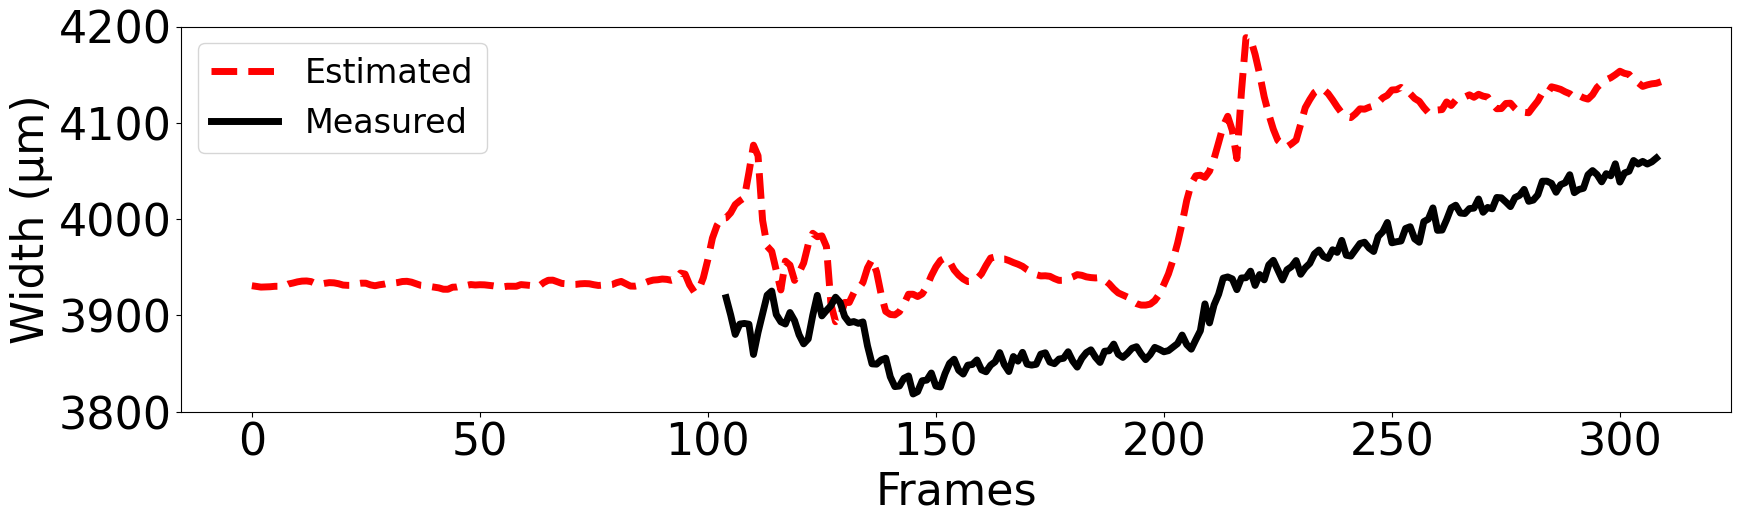

In [ ]:

# Filter the DataFrame for a specific "Video ID" (in this case, Video ID 234 that is related to the final validation measurement on a new sample)
video_id = 14
df_valid = df[df["Video ID"] == video_id]
y_pred, measured_width = width_estim(df_valid, model, processor, train_data_notnormalized, slide_window)


# Plotting configuration
plt.rcParams["figure.figsize"] = (20, 5)
font_size = 32

# Plot the data
plt.xlabel('Frames', fontdict={'size': font_size})
plt.ylabel('Width (μm)', fontdict={'size': font_size})
plt.plot(y_pred, color='red', linestyle='dashed', linewidth=5, label="Estimated")
plt.plot(range(0, len(measured_width)), measured_width, "black", linewidth=5, label="Measured")
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.legend(fontsize=24, loc='upper left')
plt.ylim(3800, 4200)



In [ ]:
hist = model.fit(X_train, y_train, epochs=2500, batch_size=16, validation_data=(X_val, y_val), shuffle=True)